In [108]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preprocessing

In [109]:
housing_df = pd.read_csv('housing.csv')

# remove all rows from 'median_house_value' that are bigger than 500000
housing_df = housing_df[housing_df['median_house_value'] <= 500000]

# remove all rows with missing values
housing_df = housing_df.dropna(subset=['total_bedrooms'])

In [110]:
train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42)

print(f"Training set: {train_set.shape}")
print(f"Test set: {test_set.shape}")

Training set: (15580, 10)
Test set: (3895, 10)


In [111]:
train_data = train_set.drop("median_house_value", axis=1)
train_labels = train_set["median_house_value"].copy()
test_data = test_set.drop("median_house_value", axis=1)
test_labels = test_set["median_house_value"].copy()

In [112]:
categorical_encoder = OneHotEncoder()
std_scaler = StandardScaler()

In [113]:
class CombinedAttributesAdder:
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert to numpy array if it's a DataFrame
        if hasattr(X, 'values'):
            X_array = X.values
        else:
            X_array = X.copy()
        
        # Now use numpy indexing on the array
        rooms_per_household = X_array[:, 3] / X_array[:, 6]  # total_rooms / households
        population_per_household = X_array[:, 5] / X_array[:, 6]  # population / households
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X_array[:, 4] / X_array[:, 3]  # total_bedrooms / total_rooms
            return np.c_[X_array, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X_array, rooms_per_household, population_per_household]

In [114]:
# Define which columns are numerical and categorical
num_features = list(train_data.select_dtypes(include=[np.number]).columns)
cat_features = ['ocean_proximity']

In [115]:
# Create preprocessing pipelines for numerical and categorical data
num_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', std_scaler)
])

# Create a full preprocessing pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', categorical_encoder, cat_features)
])

train_data_prepared = full_pipeline.fit_transform(train_data)
test_data_prepared = full_pipeline.transform(test_data)

print("Prepared training data shape:", train_data_prepared.shape)
print("Prepared test data shape:", test_data_prepared.shape)

Prepared training data shape: (15580, 16)
Prepared test data shape: (3895, 16)


In [116]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import StandardScaler

def reconstruir_dataframe(datos_preparados, full_pipeline, datos_originales, num_features, cat_features):
    """
    Reconstruye un DataFrame a partir de los datos transformados, asignando nombres de columnas correctos.
    
    Args:
        datos_preparados: Los datos después de aplicar full_pipeline.transform()
        full_pipeline: El pipeline completo de transformación
        datos_originales: DataFrame original antes de la transformación
        num_features: Lista de características numéricas
        cat_features: Lista de características categóricas
        
    Returns:
        DataFrame con nombres de columnas correctos
    """
    # Obtenemos los nombres de las columnas categóricas después de one-hot encoding
    # Extraemos el encoder del pipeline
    categorical_encoder = full_pipeline.named_transformers_['cat']
    # Obtenemos las categorías
    categorias = categorical_encoder.categories_[0]
    # Creamos los nombres de columnas para las variables categóricas codificadas
    cat_columnas = [f"{cat_features[0]}_{categoria}" for categoria in categorias]
    
    # Calculamos nombres para las columnas numéricas con atributos añadidos
    # Las columnas numéricas originales pasan por StandardScaler
    num_columnas = num_features.copy()
    
    # Añadimos los nombres de las columnas adicionales creadas por CombinedAttributesAdder
    atributos_adicionales = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
    num_columnas.extend(atributos_adicionales)
    
    # Combinamos todas las columnas en el orden correcto
    todas_columnas = num_columnas + cat_columnas
    
    # Creamos el DataFrame con los nombres de columnas
    df_reconstruido = pd.DataFrame(datos_preparados, columns=todas_columnas)
    
    return df_reconstruido

# Ejemplo de uso:
df_train_reconstruido = reconstruir_dataframe(train_data_prepared, full_pipeline, train_data, num_features, cat_features)
# df_test_reconstruido = reconstruir_dataframe(test_data_prepared, full_pipeline, test_data, num_features, cat_features)

# Models

## Random Forest baseline

Error cuadrático medio (MSE): 1992188339.67
Raíz del error cuadrático medio (RMSE): 44633.94
Coeficiente de determinación (R²): 0.7943


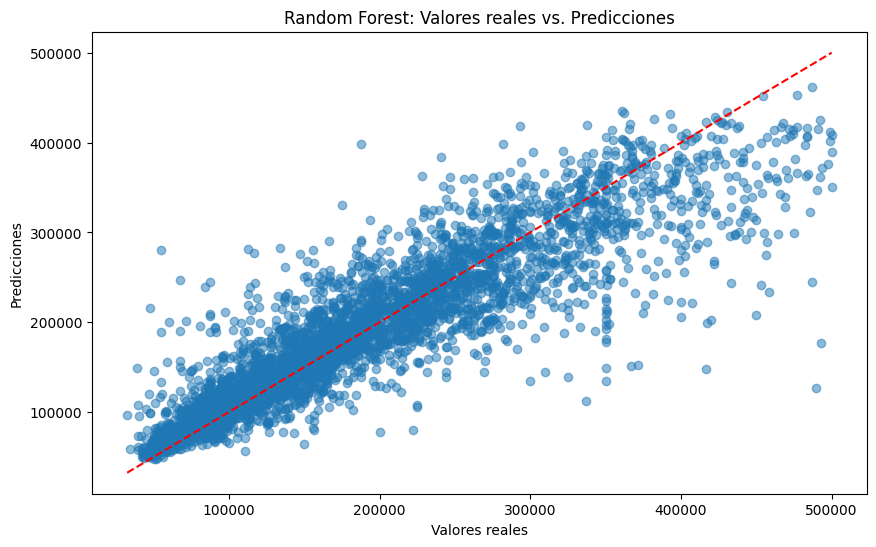

In [117]:
# Importar las bibliotecas necesarias
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Crear el modelo de Random Forest
# Puedes ajustar estos hiperparámetros según tus necesidades
rf_model = RandomForestRegressor(
    n_estimators=100,     # número de árboles
    max_depth=None,       # profundidad máxima de los árboles
    min_samples_split=2,  # muestras mínimas para dividir un nodo
    min_samples_leaf=1,   # muestras mínimas en nodos hoja
    random_state=42       # semilla para reproducibilidad
)

# Entrenar el modelo
rf_model.fit(train_data_prepared, train_labels)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(test_data_prepared)

# Evaluar el modelo
mse = mean_squared_error(test_labels, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test_labels, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")

# Visualizar las predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, y_pred, alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Random Forest: Valores reales vs. Predicciones')
plt.show()

### Feature importance

In [120]:
# Analizar la importancia de las características
feature_importance = rf_model.feature_importances_

feature_importance

array([7.49506616e-02, 6.68651268e-02, 4.50840252e-02, 1.55501934e-02,
       1.36744276e-02, 1.30383328e-02, 1.22516897e-02, 4.17338684e-01,
       2.87046242e-02, 1.18555688e-01, 3.12914240e-02, 1.48957004e-03,
       1.57128013e-01, 1.38147246e-04, 8.85336006e-04, 3.05405522e-03])

In [121]:
# Analizar la importancia de las características
feature_importance = rf_model.feature_importances_

feature_names = df_train_reconstruido.columns
# Crear un DataFrame para visualizar la importancia de las características
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

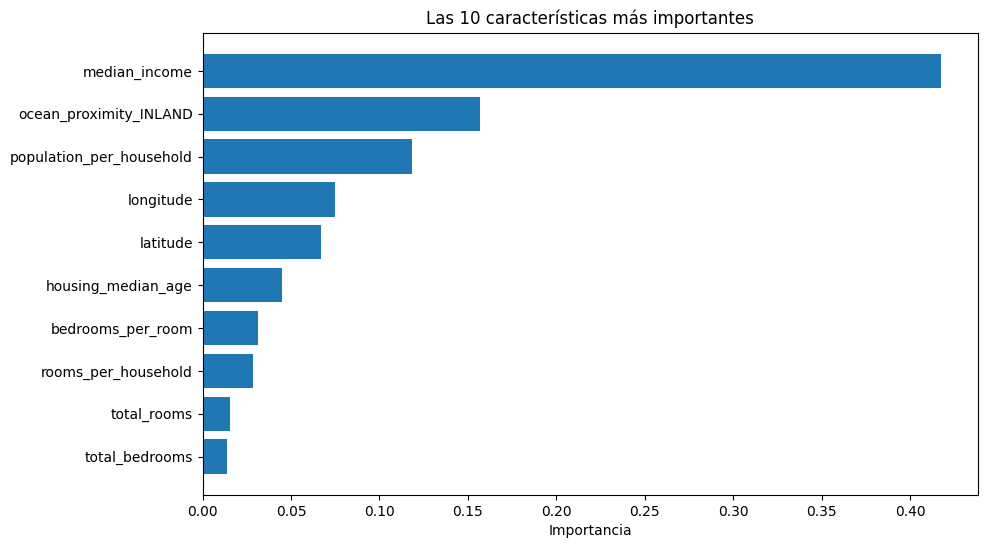

In [122]:
# Visualizar las 10 características más importantes
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Importancia')
plt.title('Las 10 características más importantes')
plt.gca().invert_yaxis()
plt.show()

## Rabdom Forest with hyperparameter tuning

In [123]:
from sklearn.model_selection import GridSearchCV

# Definir el espacio de hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

# Crear el modelo base
rf = RandomForestRegressor(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                 # validación cruzada con 5 pliegues
    scoring='neg_mean_squared_error',
    n_jobs=-1,            # usar todos los núcleos disponibles
    verbose=1
)

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(train_data_prepared, train_labels)

# Mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Mejor modelo
best_rf = grid_search.best_estimator_

# Evaluar el mejor modelo
best_pred = best_rf.predict(test_data_prepared)
best_mse = mean_squared_error(test_labels, best_pred)
best_rmse = np.sqrt(best_mse)
best_r2 = r2_score(test_labels, best_pred)

print(f"Mejor modelo - RMSE: {best_rmse:.2f}, R²: {best_r2:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


KeyboardInterrupt: 